# Electre-Tri: Sorting of potential locations of interest for a digital nomad

A digital nomad (our decision maker) is employed in tech and able to work remotely, so actually wants
to relocate to a new city as a digital nomad. The primary goals for the new location are:
1. Affordable cost of living
2. Have reliable internet connection
3. Nice weather all the year
4. A safe city
5. Nice and welcoming community
6. Reasonable distance from home city

The alternatives (cities) are:

* Lisbon
* Medellin
* Budapest
* Jakarta
* Mexico City
* Prague
* Ho Chi Minh City
* Tbilisi
* Buenos Aires
* Kuala Lumpur
* Split
* Porto
* Taipei

In [1]:
# Install all requirements
%pip install mcda==0.3.4 matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
performance_table = [
    [180, 51, 69, 98, 4.8, 1007],
    [189, 29, 46, 99, 4.6, 8527],
    [238, 44, 66, 78, 4.5, 1497],
    [35, 24, 47, 64, 4.9, 11682],
    [104, 41, 32, 92, 4.6, 9489],
    [100, 51, 75, 81, 4.5, 1353],
    [201, 28, 48, 63, 4.5, 10398],
    [42, 34, 74, 84, 4.3, 3511],
    [115, 44, 36, 98, 4.4, 10465],
    [142, 35, 39, 57, 4.4, 10567],
    [103, 52, 69, 96, 4.6, 1192],
    [217, 45, 67, 97, 4.5, 900],
    [225, 53, 84, 84, 4.6, 10346],
]

alternatives = [
    "lisbon",
    "medellin",
    "budapest",
    "jakarta",
    "mexico_city",
    "prague",
    "ho_chi_minh_city",
    "tbilisi",
    "buenos_aires",
    "kuala_lumpur",
    "split",
    "porto",
    "taipei",
]

criteria = ["internet", "cost_of_living", "safety", "climate", "rating", "distance"]

LOW_LAMBDA = 0.6
MID_LAMBDA = 0.75
HIGH_LAMBDA = 0.85

equal_weights = [0.167, 0.167, 0.167, 0.167, 0.166, 0.166]
safety_weights =  [0.15, 0.35, 0.1, 0.15, 0.1, 0.15]
cost_weights =  [0.15, 0.35, 0.1, 0.15, 0.1, 0.15]


Let's analyze a bit the data from the performance table first

/tmp/ipykernel_379682/3687664082.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


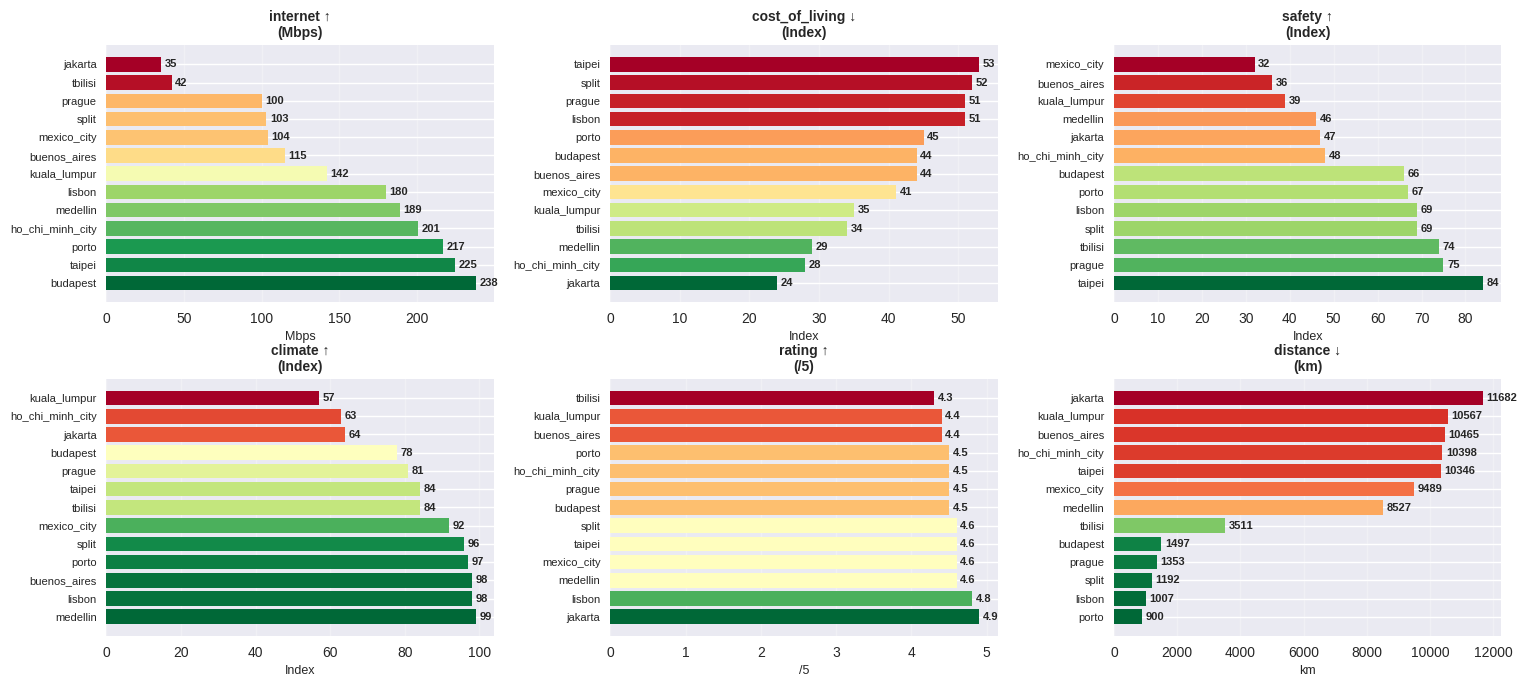

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

criteria_units = ["Mbps", "Index", "Index", "Index", "/5", "km"]
criteria_direction = ["↑", "↓", "↑", "↑", "↑", "↓"]

df = pd.DataFrame(performance_table, columns=criteria, index=alternatives)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors = plt.cm.Set3(np.linspace(0, 1, len(alternatives)))
criteria_colors = plt.cm.Dark2(np.linspace(0, 1, len(criteria)))

# create a bar chart for each criterion
for i in range(len(criteria)):
    row = (i // 3) + 1
    col = i % 3
    ax = fig.add_subplot(gs[row, col])
    
    # sort cities according to direction
    criterion_data = df[criteria[i]].copy()
    if criteria_direction[i] == "↓":
        sorted_data = criterion_data.sort_values(ascending=True)
        color_map = plt.cm.RdYlGn_r
    else:
        sorted_data = criterion_data.sort_values(ascending=False)
        color_map = plt.cm.RdYlGn
    
    # create color gradients
    norm_values = (sorted_data.values - sorted_data.min()) / (sorted_data.max() - sorted_data.min())
    bar_colors = color_map(norm_values)
    
    bars = ax.barh(range(len(sorted_data)), sorted_data.values, color=bar_colors)
    
    # add labels
    for j, (city, value) in enumerate(sorted_data.items()):
        ax.text(value + sorted_data.max() * 0.01, j, f'{value}', 
                va='center', fontsize=8, fontweight='bold')
    
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data.index, fontsize=8)
    ax.set_xlabel(f'{criteria_units[i]}', fontsize=9)
    ax.set_title(f'{criteria[i]} {criteria_direction[i]}\n({criteria_units[i]})', 
                fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Our decision maker gives the same importance to cost of living, internet, safety and distance, but lower importance to rating and climate.

Now we're going to set the ranges and the directions of the criteria values.

In [4]:
from mcda.core.scales import *

scale_internet = QuantitativeScale(35, 238, PreferenceDirection.MAX)
scale_cost_of_living = QuantitativeScale(24, 53, PreferenceDirection.MIN)
scale_safety = QuantitativeScale(32, 84, PreferenceDirection.MAX)
scale_climate = QuantitativeScale(57, 99, PreferenceDirection.MAX)
scale_rating = QuantitativeScale(4.3, 4.9, PreferenceDirection.MAX)
scale_distance = QuantitativeScale(900, 11682, PreferenceDirection.MIN)

scales = [scale_internet, scale_cost_of_living, scale_safety, scale_climate, scale_rating, scale_distance]

Now let's define the poor and good profiles used to sort the different alternatives

In [5]:
profile_names = ["poor", "good"]

profile_values = [
    [150, 40, 55, 75, 4.5, 5000],
    [200, 35, 70, 85, 4.7, 3000],
]

Now let's define the indifference, preference and veto thresholds

In [6]:
# Indifference thresholds (q)
relaxed_indifference_thresholds = [15, 5, 8, 8, 0.15, 800]
strict_indifference_thresholds = [5, 2, 3, 3, 0.05, 300]

# Preference thresholds (p)
relaxed_preference_thresholds = [35, 9, 15, 15, 0.3, 2000]
strict_preference_thresholds = [15, 4, 6, 6, 0.1, 1000]

# Veto thresholds (v)
relaxed_veto_thresholds = [70, 18, 30, 30, 0.6, 4000]
strict_veto_thresholds = [35, 8, 15, 15, 0.3, 2000]

Now let's calculate the credibility, the pesimistic and optimistic results

In [7]:
import mcda.outranking.electre_tri as electre_tri

def clean_matrix (lst):
  matrix = []
  for row in lst:
    r = []
    for x in row:
      r.append(round(x, 3))
    matrix.append(r)
  return matrix

credibilityValuesAll = electre_tri.credibility(
  performance_table,
  safety_weights,
  scales, 
  relaxed_preference_thresholds,
  relaxed_indifference_thresholds,
  relaxed_veto_thresholds,
)
clean_matrix(credibilityValuesAll)

pessimistic = electre_tri.pessimistic_procedure(
  performance_table,
  profile_values,
  safety_weights,
  scales, 
  relaxed_preference_thresholds,
  relaxed_indifference_thresholds,
  relaxed_veto_thresholds,
  LOW_LAMBDA
)
optimistic=electre_tri.optimistic_procedure(
  performance_table,
  profile_values,
  safety_weights,
  scales, 
  relaxed_preference_thresholds,
  relaxed_indifference_thresholds,
  relaxed_veto_thresholds,
  LOW_LAMBDA
)

TypeError: 'list' object is not callable

Now let's plot the results:

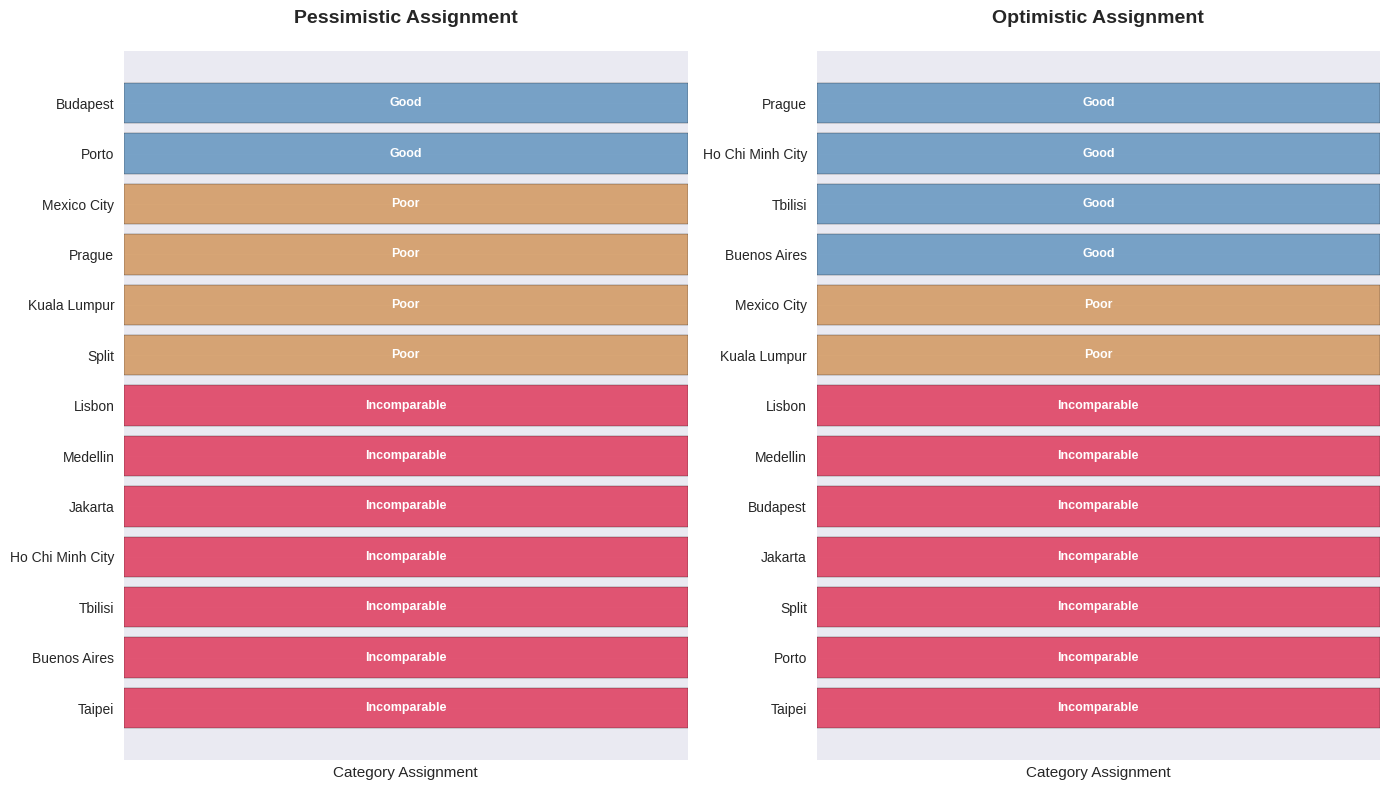

In [10]:
from typing import Any
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
category_names = {2: 'Excellent', 1: 'Good', 0: 'Poor', -1: 'Incomparable'}
category_colors = {2: '#2E8B57', 1: '#4682B4', 0: '#CD853F', -1: '#DC143C'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

def plot_assignment(ax: Any, results: dict[int, list[int]], title: str) -> None:
    """
    plots the given results with a horizontal bar chart
    """
    category_data = {}
    for category, indices in results.items():
        cities = [alternatives[i] for i in indices]
        category_data[category] = cities
    
    all_cities = []
    categories = []
    colors = []
    
    for cat in [2, 1, 0, -1]:
        if cat in category_data and category_data[cat]:
            for city in category_data[cat]:
                all_cities.append(city)
                categories.append(category_names[cat])
                colors.append(category_colors[cat])
    
    # create horizontal bar chart
    y_pos = range(len(all_cities))
    bars = ax.barh(y_pos, [1] * len(all_cities), color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(all_cities, fontsize=10)
    ax.set_xlabel('Category Assignment', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    
    # add category labels
    for i, (bar, category) in enumerate(zip(bars, categories)):
        ax.text(0.5, bar.get_y() + bar.get_height()/2, category, 
                ha='center', va='center', fontweight='bold', fontsize=9, color='white')
    ax.grid(axis='y', alpha=0.3)
    ax.invert_yaxis()

plot_assignment(ax1, pessimistic, 'Pessimistic Assignment')
plot_assignment(ax2, optimistic, 'Optimistic Assignment')

plt.tight_layout()
plt.show()